Import necessary libraries


In [1]:
import os
import zipfile
import random
import json
import string
import ast
import numpy as np
import torch
import requests
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

Check for cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Extract Dataset

In [3]:
root_dir = ''
print(root_dir)

data_dir = os.path.join(root_dir,"nist_dataset/")
data_resource = "https://s3.amazonaws.com/nist-srd/SD19/by_class.zip"
zip_dir = os.path.join(data_dir, "by_class.zip")
extracted_data_dir = os.path.join(data_dir, "extracted/")

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

    with open(zip_dir, 'wb') as out_file:
        content = requests.get(data_resource, stream=True).content
        out_file.write(content)

    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
        # Get list of all files in the ZIP
        file_list = zip_ref.namelist()

        # Show progress
        with tqdm(total=len(file_list), desc="Extracting Files", unit="file") as progress_bar:
            for file in file_list:
                zip_ref.extract(file, extracted_data_dir)  # Extract each file
                progress_bar.update(1)
else:
    print(f"Dataset already extracted at {extracted_data_dir}")


Dataset already extracted at nist_dataset/extracted/


Extract data from zip

In [5]:
zip_path = "nist_dataset/by_class.zip"  # Path to zip file
extract_dir = "by_class"  # Directory where the dataset will be extracted

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get list of all files in the ZIP
        file_list = zip_ref.namelist()

        # Show progress
        with tqdm(total=len(file_list), desc="Extracting Files", unit="file") as progress_bar:
            for file in file_list:
                zip_ref.extract(file, extract_dir)  # Extract each file
                progress_bar.update(1)
else:
    print(f"Dataset already extracted at {extract_dir}")


Dataset already extracted at by_class


Parse through data folders for images

In [6]:
img_paths, labels = [], [] # empty lists to store file paths and labels

ascii_folders = os.listdir("by_class/by_class/")
for ascii_num in ascii_folders:
    # Convert folder name from hexadecimal to ASCII character
    label = chr(int(ascii_num, 16))
    train_folder = f"by_class/by_class/{ascii_num}/train_{ascii_num}"

    if os.path.exists(train_folder):
        # Loop through each file in the train_folder
        for file in os.listdir(train_folder):
            if file.endswith(".png"):
                # Add full path to the list of image paths
                img_paths.append(os.path.join(train_folder, file))
                labels.append(label)

print(f"Total samples: {len(img_paths)}")

Total samples: 731668


Generate sythetic dataset for multiple-character recognition

In [7]:
# Function to generate synthetic multi-character data
def generate_synthetic_data(
    char_images, labels, output_dir, num_samples=50000, max_length=10, image_height=32
):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory
    # Clear labels.txt at the start
    open(os.path.join(output_dir, "labels.txt"), "w").close()

    for i in tqdm(range(num_samples), desc="Generating Data"):
        line_images = []  # Stores character images
        line_label = []   # Stores character labels
        total_width = 0   # Tracks total width for the line canvas

        # Choose line length
        line_len = 5

        # Randomly sample characters for the line
        sampled_indices = random.choices(range(len(char_images)), k=line_len)
        for idx in sampled_indices:
            # Open and convert character image to grayscale
            selected_image = Image.open(char_images[idx]).convert('L')
            line_images.append(selected_image)  # Add image to list
            line_label.append(labels[idx])      # Add label to list

        # Calculate total width of the line
        char_spacing = 5  # Spacing between characters
        max_char_width = 50  # Maximum width for each character
        for img in line_images:
            aspect_ratio = img.size[0] / img.size[1]  # width / height for image scaling
            new_width = min(int(image_height * aspect_ratio), max_char_width)
            total_width += new_width + char_spacing

        total_width -= char_spacing  # Remove spacing after the last character

        # Create a blank canvas to draw
        character_line = Image.new('L', (total_width, image_height), color=255)

        # Paste resized characters onto the canvas
        x_offset = 0
        for img in line_images: # Iterate through
            aspect_ratio = img.size[0] / img.size[1]
            new_width = min(int(image_height * aspect_ratio), max_char_width)
            resized_img = img.resize((new_width, image_height)) # Resize image
            character_line.paste(resized_img, (x_offset, 0))    # Draw character into current location
            x_offset += new_width + char_spacing # Calculate new x offset

        # Save the synthetic line image
        image_filename = f"line_{i:04d}.png"
        character_line.save(os.path.join(output_dir, image_filename))

        # Write the fine name and list into labels.txt (ground truth)
        with open(os.path.join(output_dir, "labels.txt"), "a") as label_file:
            label_file.write(f"{image_filename} {str(line_label)}\n")

# Generate data
output_dir = 'synthetic_data'                           # Control number of samples here
generate_synthetic_data(img_paths, labels, output_dir, num_samples=50000, max_length=10, image_height=32)

Generating Data: 100%|██████████| 50000/50000 [02:04<00:00, 402.08it/s]


Map characters to indicies and set number of classes

In [63]:
# Define the character set
# 0 is reserved for the CTC blank token
characters = string.ascii_lowercase + string.ascii_uppercase + string.digits
num_classes = len(characters) + 1  # +1 for the blank

# Create a dictionary to map indices to characters
# So start mapping from 1
idx_to_char = {i + 1: char for i, char in enumerate(characters)}
idx_to_char[0] = ''  # Blank token

Create dataset object to hold sample data

In [54]:
class MultiCharacterOCRDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Read the label file
        label_path = os.path.join(data_dir, "labels.txt")
        with open(label_path, "r") as label_file:
            for line in label_file:
                # Expected format: image_filename "label_string"
                parts = line.strip().split(" ", 1)
                if len(parts) != 2: # Check for 2 lines exactly
                    continue  # Skip malformed lines
                image_file, label_str = parts # unpack
                self.image_paths.append(os.path.join(data_dir, image_file)) # Construct full path to image
                label = ast.literal_eval(label_str)  # Convert string rep to list
                # Map characters to indices, default to blank (0) if character not found
                #label_idx = [char_2_idx.get(char, blank_idx) for char in label]
                label_idx = [char_2_idx[char] for char in label]
                self.labels.append(label_idx) # add label to labels list

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image in grayscale
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform: # Apply transformation if needed
            image = self.transform(image)
        label = self.labels[idx]    # Retreive label, return label and image
        return image, torch.tensor(label, dtype=torch.long)

char_2_idx = {char: i + 1 for i, char in enumerate(characters)}
char_2_idx[''] = 0  # Blank token

Define transforms and dataset

In [55]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 256)),  # Resize to 32 x 256 for consistency
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

blank_idx = 0  # blank token
# Create a mapping from characters to indices
# Start indexing from 1 since 0 is reserved for the blank token


# Instantiate the dataset
data_dir = "synthetic_data"
dataset = MultiCharacterOCRDataset(data_dir, transform=transform)


Visualize some dataset samples

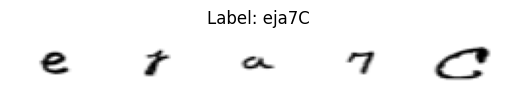

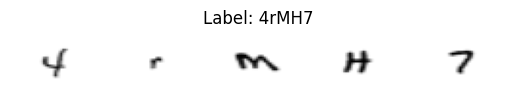

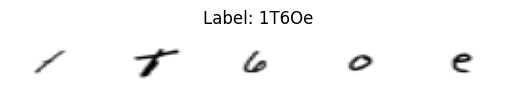

In [56]:
# Create a reverse mapping from indices to characters
idx_2_char = {idx: char for char, idx in char_2_idx.items()}

# Add the blank token to the idx_to_char mapping
idx_2_char[blank_idx] = ''  # Empty string or any placeholder for the blank token

# Visualize some samples
for i in range(3):
    characters = []
    image, label = dataset[i]
    plt.imshow(image.squeeze(0).numpy(), cmap='gray')
    # Convert label indices back to characters
    # Iterate through each index in the 'label' list
    for idx in label:
        # Convert the tensor element to a standard Python integer
        index = idx.item()

        # Retrieve the corresponding character from the 'idx_to_char' dictionary
        # If the index is not found, use '?' as a placeholder
        char = idx_2_char.get(index, '?')

        # Append the character to the 'characters' list
        characters.append(char)

    # Concatenate all characters into a single string
    label_chars = ''.join(characters)

    plt.title(f"Label: {label_chars}")
    plt.axis('off')
    plt.show()


Split dataset samples into train, validation, and test

In [57]:

# Total number of samples
dataset_size = len(dataset)

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no rounding errors

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 40000
Validation samples: 5000
Test samples: 5000


Initailize dataloaders

In [58]:
# Batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 625
Validation batches: 79
Test batches: 79


Define OCR Model

In [65]:
class OCRModel(nn.Module):
    def __init__(self, num_classes=num_classes, hidden_size=256, num_layers=2):
        super(OCRModel, self).__init__()

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Input: (1, 32, 256), Output: (64, 32, 256)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization for the first convolutional layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # Input: (64, 32, 256), Output: (128, 32, 256)
        self.bn2 = nn.BatchNorm2d(128)# Batch normalization for the second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)# Pooling reduces spatial dimensions by half (kernel_size=2, stride=2)

        # LSTM for sequence modeling
        # After three pooling layers:
        # Height: 32 -> 16 -> 8 -> 4
        # Width: 256 -> 128 -> 64 -> 32
        self.lstm_input_size = 256 * 4  # channels * height after pooling (256 * 4 = 1024)
        self.lstm_hidden_size = hidden_size# Hidden size for the LSTM
        self.lstm_num_layers = num_layers# Number of LSTM layers

        # Using bidirectional LSTM
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,# Input size: 1024
                            hidden_size=self.lstm_hidden_size,
                            num_layers=self.lstm_num_layers,
                            batch_first=True,
                            bidirectional=True)

        # Fully connected layer to predict character classes
        # Multiply hidden size by 2 for bidirectional LSTM
        self.fc = nn.Linear(self.lstm_hidden_size * 2, num_classes)

    def forward(self, x):
        # x: [batch_size, 1, 32, 256]
        # First convolutional block: Convolution -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [batch_size, 64, 16, 128]
        #x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 64, 16, 128]
        # Second convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [batch_size, 128, 8, 64]


        # Reshape for LSTM input
        batch_size = x.size(0)  # Batch size
        seq_len = x.size(3)  # Sequence length (width after pooling)
        # Current x shape: [batch_size, 256, 4, 32]

        # Permute and reshape: [batch_size, seq_len, channels * height]
        x = x.permute(0, 3, 1, 2).contiguous()# Permute to [batch_size, seq_len=32, channels=256, height=4]
        x = x.view(batch_size, seq_len, -1)  # Flatten channels and height: [batch_size, 32, 256*4=1024]


        # LSTM
        x, _ = self.lstm(x)  # Output: [batch_size, 32, hidden_size*2]

        # Fully connected layer
        x = self.fc(x)  # Output: [batch_size, 32, num_classes]

        return x


Greedy Decoding Method

In [14]:
#     Decodes the output of model using greedy approach.
def greedy_decode(output, blank=0):
    # Find the class with the maximum probability at each time step
    max_probs, max_idxs = torch.max(output, dim=2)  # [T, N]
    # Transpose max_idxs to have the batch dimension first
    max_idxs = max_idxs.transpose(0, 1)  # [N, T]
    decoded_sequences = [] # List to store the decoded sequences for each batch item
    # Iterate over each sequence in the batch
    for seq in max_idxs:
        decoded = []
        prev = blank # Track the previous index
            # Iterate over each index in the sequence
        for idx in seq:
            idx = idx.item()
                # Append the index if it's not blank and not the same as the previous index
            if idx != blank and idx != prev:
                decoded.append(idx)
            prev = idx  # Update the previous index
        decoded_sequences.append(decoded) # Add the decoded sequence to the list
    return decoded_sequences

Plot training/validation metrics

In [19]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 15))

    # Plot Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Sequence Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_seq_acc'], 'b-', label='Training Sequence Accuracy')
    plt.plot(epochs, history['val_seq_acc'], 'r-', label='Validation Sequence Accuracy')
    plt.title('Training and Validation Sequence Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot Character Accuracy
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_char_acc'], 'g-', label='Training Character Accuracy')
    plt.plot(epochs, history['val_char_acc'], 'y-', label='Validation Character Accuracy')
    plt.title('Training and Validation Character Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


Define training and validation loops

In [61]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    # Move the model to GPU
    model.to(device)
    model.train()# Set model to training mode
    # Initialize history to track metrics
    # Define
    criterion = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_char_acc': [],
        'val_char_acc': [],
        'train_seq_acc': [],
        'val_seq_acc': []

    }
    # Early stopping parameters
    best_seq_acc, epochs_no_improve, patience = 0.0, 0, 5


    for epoch in range(num_epochs):
        running_loss, correct_seqs, total_seqs, correct_chars, total_chars  = 0.0, 0, 0, 0, 0
        # Initialize metrics for the current epoch

        # Training loop
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero gradients before backpropagation
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # [batch_size, seq_len, num_classes]
            outputs = outputs.permute(1, 0, 2) # Transpose for CTC loss: [seq_len, batch_size, num_classes]
            outputs = F.log_softmax(outputs, dim=2) # Apply log-softmax for CTC


            # Flatten targets for CTC loss
            targets = labels.contiguous().view(-1)

            # Define input_lengths, target_lengths for CTC
            batch_size = images.size(0)
            input_lengths = torch.full((batch_size,), outputs.size(0), dtype=torch.long, device=device)  # [batch_size]
            target_lengths = torch.full((batch_size,), labels.size(1), dtype=torch.long)  # [batch_size]

            #print("Targets:", targets[:5].tolist())

            # Compute CTC loss
            loss = criterion(outputs, targets, input_lengths, target_lengths)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss

            running_loss += loss.item()

            # Decode model predictions
            decoded_sequences = greedy_decode(outputs.detach().cpu(), blank=blank_idx)
            target_sequences = labels.detach().cpu().tolist()

            # Compute sequence & character accuracy
            for i in range(len(decoded_sequences)):
                pred = decoded_sequences[i]  # Predicted seq
                target = target_sequences[i]  # Target seq

                # Check if the pred seq matches the target seq
                if pred == target:
                    correct_seqs += 1

                # Compute character-level accuracy
                for j in range(len(target)):
                    if j < len(pred) and pred[j] == target[j]:
                        correct_chars += 1
                total_chars += len(target)

            total_seqs += len(decoded_sequences)

        # Compute metrics for train set
        epoch_loss = running_loss / len(train_loader)
        character_accuracy = correct_chars / total_chars * 100
        sequence_accuracy = correct_seqs / total_seqs * 100

        # Store validation metrics in history
        history['train_loss'].append(epoch_loss)
        history['train_char_acc'].append(character_accuracy)
        history['train_seq_acc'].append(sequence_accuracy)


        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Sequence Accuracy: {sequence_accuracy:.2f}%, "
              f"Character Accuracy: {character_accuracy:.2f}%\n")

        # Perform validation
        val_loss, val_seq_acc, val_char_acc = validate_model(model, val_loader, device)

        history['val_loss'].append(val_loss)
        history['val_seq_acc'].append(val_seq_acc)
        history['val_char_acc'].append(val_char_acc)

        # Save the best model based on validation sequence accuracy
        if val_seq_acc > best_seq_acc:
            best_seq_acc = val_seq_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_ocr_model.pth")
            print("Saved Best Model\n")
        else:
            epochs_no_improve += 1
            print(f"No improvement in sequence accuracy for {epochs_no_improve} epoch(s).")

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

        scheduler.step()

    plot_metrics(history)

def validate_model(model, val_loader, device='cuda'):
    model.eval()  # Set the model to evaluation mode during validation/inference
    criterion = nn.CTCLoss(blank=blank_idx, zero_infinity=True)
    running_loss, correct_seqs, total_seqs, correct_chars, total_chars  = 0.0, 0, 0, 0, 0

    with torch.no_grad():# Disable gradient comp for validation
        for images, labels in tqdm(val_loader, desc="Validation"):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)  # [batch_size, seq_len, num_classes]
            outputs = outputs.permute(1, 0, 2)  # Transpose for CTC loss]
            outputs = F.log_softmax(outputs, dim=2)   # Apply log-softmax for CTC

            # Flatten targetsfor CTC
            targets = labels.contiguous().view(-1)  # [batch_size * seq_len]

            # Define input_lengths and target_lengths for CTC
            batch_size = images.size(0)
            input_lengths = torch.full((batch_size,), outputs.size(0), dtype=torch.long, device=device)  # [batch_size]
            target_lengths = torch.full((batch_size,), labels.size(1), dtype=torch.long)  # [batch_size]

            # Compute CTC loss
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            running_loss += loss.item()

            # Decode model predictions
            decoded_sequences = greedy_decode(outputs.detach().cpu(), blank=blank_idx)
            target_sequences = labels.detach().cpu().tolist()

            # Compute sequence & character accuracy
            for i in range(len(decoded_sequences)):
                pred = decoded_sequences[i]  # Predicted sequence
                target = target_sequences[i]  # Target sequence

                # Check if the predicted sequence matches the target sequence
                if pred == target:
                    correct_seqs += 1

                # Compute character-level accuracy
                for j in range(len(target)):
                    if j < len(pred) and pred[j] == target[j]:
                        correct_chars += 1
                total_chars += len(target)

            total_seqs += len(decoded_sequences)


    # Compute metrics for the validation set
    epoch_loss = running_loss / len(val_loader)
    sequence_accuracy = correct_seqs / total_seqs * 100
    character_accuracy = correct_chars / total_chars * 100

    print(f"Validation Loss: {epoch_loss:.4f}, "
          f"Sequence Accuracy: {sequence_accuracy:.2f}%, "
          f"Character Accuracy: {character_accuracy:.2f}%\n")

    model.train()
    return epoch_loss, sequence_accuracy, character_accuracy

Run training block

Epoch 1/30: 100%|██████████| 625/625 [00:17<00:00, 35.02it/s]



Epoch [1/30], Loss: 4.7890, Sequence Accuracy: 0.00%, Character Accuracy: 0.00%



Validation: 100%|██████████| 79/79 [00:01<00:00, 43.83it/s]


Validation Loss: 3.9757, Sequence Accuracy: 0.00%, Character Accuracy: 0.00%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 2/30: 100%|██████████| 625/625 [00:17<00:00, 35.37it/s]



Epoch [2/30], Loss: 2.9605, Sequence Accuracy: 1.02%, Character Accuracy: 7.23%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.32it/s]


Validation Loss: 1.4228, Sequence Accuracy: 11.52%, Character Accuracy: 50.48%

Saved Best Model



Epoch 3/30: 100%|██████████| 625/625 [00:17<00:00, 35.53it/s]



Epoch [3/30], Loss: 0.9158, Sequence Accuracy: 25.97%, Character Accuracy: 71.28%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.96it/s]


Validation Loss: 0.6731, Sequence Accuracy: 34.70%, Character Accuracy: 78.62%

Saved Best Model



Epoch 4/30: 100%|██████████| 625/625 [00:17<00:00, 35.25it/s]



Epoch [4/30], Loss: 0.5858, Sequence Accuracy: 39.54%, Character Accuracy: 81.58%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.87it/s]


Validation Loss: 0.5282, Sequence Accuracy: 41.62%, Character Accuracy: 83.14%

Saved Best Model



Epoch 5/30: 100%|██████████| 625/625 [00:18<00:00, 34.64it/s]



Epoch [5/30], Loss: 0.4873, Sequence Accuracy: 44.66%, Character Accuracy: 84.29%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.41it/s]


Validation Loss: 0.4728, Sequence Accuracy: 43.58%, Character Accuracy: 84.34%

Saved Best Model



Epoch 6/30: 100%|██████████| 625/625 [00:17<00:00, 35.00it/s]



Epoch [6/30], Loss: 0.4277, Sequence Accuracy: 48.42%, Character Accuracy: 85.98%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.64it/s]


Validation Loss: 0.4345, Sequence Accuracy: 46.56%, Character Accuracy: 85.13%

Saved Best Model



Epoch 7/30: 100%|██████████| 625/625 [00:17<00:00, 35.30it/s]



Epoch [7/30], Loss: 0.4066, Sequence Accuracy: 49.70%, Character Accuracy: 86.51%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.96it/s]


Validation Loss: 0.4179, Sequence Accuracy: 48.16%, Character Accuracy: 85.64%

Saved Best Model



Epoch 8/30: 100%|██████████| 625/625 [00:17<00:00, 35.62it/s]



Epoch [8/30], Loss: 0.3885, Sequence Accuracy: 50.90%, Character Accuracy: 86.99%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.74it/s]


Validation Loss: 0.4105, Sequence Accuracy: 49.00%, Character Accuracy: 86.24%

Saved Best Model



Epoch 9/30: 100%|██████████| 625/625 [00:17<00:00, 35.83it/s]



Epoch [9/30], Loss: 0.3750, Sequence Accuracy: 51.73%, Character Accuracy: 87.35%



Validation: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Validation Loss: 0.4000, Sequence Accuracy: 49.20%, Character Accuracy: 86.26%

Saved Best Model



Epoch 10/30: 100%|██████████| 625/625 [00:17<00:00, 35.00it/s]



Epoch [10/30], Loss: 0.3620, Sequence Accuracy: 52.80%, Character Accuracy: 87.74%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.89it/s]


Validation Loss: 0.3933, Sequence Accuracy: 49.58%, Character Accuracy: 86.55%

Saved Best Model



Epoch 11/30: 100%|██████████| 625/625 [00:17<00:00, 35.69it/s]



Epoch [11/30], Loss: 0.3406, Sequence Accuracy: 54.91%, Character Accuracy: 88.45%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.36it/s]


Validation Loss: 0.3808, Sequence Accuracy: 50.54%, Character Accuracy: 86.86%

Saved Best Model



Epoch 12/30: 100%|██████████| 625/625 [00:17<00:00, 36.04it/s]



Epoch [12/30], Loss: 0.3340, Sequence Accuracy: 55.35%, Character Accuracy: 88.61%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.58it/s]


Validation Loss: 0.3780, Sequence Accuracy: 50.58%, Character Accuracy: 86.92%

Saved Best Model



Epoch 13/30: 100%|██████████| 625/625 [00:18<00:00, 34.57it/s]



Epoch [13/30], Loss: 0.3285, Sequence Accuracy: 55.81%, Character Accuracy: 88.78%



Validation: 100%|██████████| 79/79 [00:01<00:00, 46.11it/s]


Validation Loss: 0.3735, Sequence Accuracy: 50.90%, Character Accuracy: 87.05%

Saved Best Model



Epoch 14/30: 100%|██████████| 625/625 [00:17<00:00, 35.63it/s]



Epoch [14/30], Loss: 0.3228, Sequence Accuracy: 56.32%, Character Accuracy: 88.95%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.36it/s]


Validation Loss: 0.3777, Sequence Accuracy: 50.66%, Character Accuracy: 86.96%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 15/30: 100%|██████████| 625/625 [00:17<00:00, 35.42it/s]



Epoch [15/30], Loss: 0.3169, Sequence Accuracy: 56.87%, Character Accuracy: 89.16%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.60it/s]


Validation Loss: 0.3697, Sequence Accuracy: 51.24%, Character Accuracy: 87.22%

Saved Best Model



Epoch 16/30: 100%|██████████| 625/625 [00:17<00:00, 35.18it/s]



Epoch [16/30], Loss: 0.3062, Sequence Accuracy: 57.84%, Character Accuracy: 89.49%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.08it/s]


Validation Loss: 0.3655, Sequence Accuracy: 51.58%, Character Accuracy: 87.30%

Saved Best Model



Epoch 17/30: 100%|██████████| 625/625 [00:17<00:00, 35.66it/s]



Epoch [17/30], Loss: 0.3031, Sequence Accuracy: 58.26%, Character Accuracy: 89.61%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.95it/s]


Validation Loss: 0.3633, Sequence Accuracy: 51.98%, Character Accuracy: 87.30%

Saved Best Model



Epoch 18/30: 100%|██████████| 625/625 [00:17<00:00, 35.30it/s]



Epoch [18/30], Loss: 0.3003, Sequence Accuracy: 58.53%, Character Accuracy: 89.71%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.61it/s]


Validation Loss: 0.3638, Sequence Accuracy: 51.60%, Character Accuracy: 87.27%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 19/30: 100%|██████████| 625/625 [00:17<00:00, 35.20it/s]



Epoch [19/30], Loss: 0.2975, Sequence Accuracy: 58.81%, Character Accuracy: 89.77%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.10it/s]


Validation Loss: 0.3625, Sequence Accuracy: 51.76%, Character Accuracy: 87.45%

No improvement in sequence accuracy for 2 epoch(s).


Epoch 20/30: 100%|██████████| 625/625 [00:17<00:00, 35.00it/s]



Epoch [20/30], Loss: 0.2949, Sequence Accuracy: 59.00%, Character Accuracy: 89.87%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.97it/s]


Validation Loss: 0.3617, Sequence Accuracy: 51.88%, Character Accuracy: 87.47%

No improvement in sequence accuracy for 3 epoch(s).


Epoch 21/30: 100%|██████████| 625/625 [00:17<00:00, 36.03it/s]



Epoch [21/30], Loss: 0.2892, Sequence Accuracy: 59.67%, Character Accuracy: 90.09%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.25it/s]


Validation Loss: 0.3596, Sequence Accuracy: 52.02%, Character Accuracy: 87.48%

Saved Best Model



Epoch 22/30: 100%|██████████| 625/625 [00:17<00:00, 35.15it/s]



Epoch [22/30], Loss: 0.2874, Sequence Accuracy: 59.77%, Character Accuracy: 90.10%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.24it/s]


Validation Loss: 0.3605, Sequence Accuracy: 51.94%, Character Accuracy: 87.42%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 23/30: 100%|██████████| 625/625 [00:17<00:00, 35.50it/s]



Epoch [23/30], Loss: 0.2861, Sequence Accuracy: 59.91%, Character Accuracy: 90.16%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.19it/s]


Validation Loss: 0.3594, Sequence Accuracy: 52.28%, Character Accuracy: 87.60%

Saved Best Model



Epoch 24/30: 100%|██████████| 625/625 [00:17<00:00, 35.16it/s]



Epoch [24/30], Loss: 0.2845, Sequence Accuracy: 60.08%, Character Accuracy: 90.25%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.68it/s]


Validation Loss: 0.3588, Sequence Accuracy: 52.06%, Character Accuracy: 87.53%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 25/30: 100%|██████████| 625/625 [00:17<00:00, 35.01it/s]



Epoch [25/30], Loss: 0.2833, Sequence Accuracy: 60.16%, Character Accuracy: 90.26%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.13it/s]


Validation Loss: 0.3599, Sequence Accuracy: 52.04%, Character Accuracy: 87.38%

No improvement in sequence accuracy for 2 epoch(s).


Epoch 26/30: 100%|██████████| 625/625 [00:17<00:00, 35.51it/s]



Epoch [26/30], Loss: 0.2803, Sequence Accuracy: 60.65%, Character Accuracy: 90.40%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.35it/s]


Validation Loss: 0.3587, Sequence Accuracy: 52.28%, Character Accuracy: 87.53%

No improvement in sequence accuracy for 3 epoch(s).


Epoch 27/30: 100%|██████████| 625/625 [00:18<00:00, 34.33it/s]



Epoch [27/30], Loss: 0.2795, Sequence Accuracy: 60.73%, Character Accuracy: 90.43%



Validation: 100%|██████████| 79/79 [00:01<00:00, 45.41it/s]


Validation Loss: 0.3582, Sequence Accuracy: 52.40%, Character Accuracy: 87.59%

Saved Best Model



Epoch 28/30: 100%|██████████| 625/625 [00:17<00:00, 35.20it/s]



Epoch [28/30], Loss: 0.2788, Sequence Accuracy: 60.60%, Character Accuracy: 90.40%



Validation: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Validation Loss: 0.3583, Sequence Accuracy: 52.40%, Character Accuracy: 87.63%

No improvement in sequence accuracy for 1 epoch(s).


Epoch 29/30: 100%|██████████| 625/625 [00:17<00:00, 35.39it/s]



Epoch [29/30], Loss: 0.2782, Sequence Accuracy: 60.90%, Character Accuracy: 90.47%



Validation: 100%|██████████| 79/79 [00:01<00:00, 44.37it/s]


Validation Loss: 0.3590, Sequence Accuracy: 52.48%, Character Accuracy: 87.67%

Saved Best Model



Epoch 30/30: 100%|██████████| 625/625 [00:17<00:00, 35.07it/s]



Epoch [30/30], Loss: 0.2775, Sequence Accuracy: 60.92%, Character Accuracy: 90.50%



Validation: 100%|██████████| 79/79 [00:01<00:00, 41.08it/s]


Validation Loss: 0.3584, Sequence Accuracy: 52.20%, Character Accuracy: 87.53%

No improvement in sequence accuracy for 1 epoch(s).


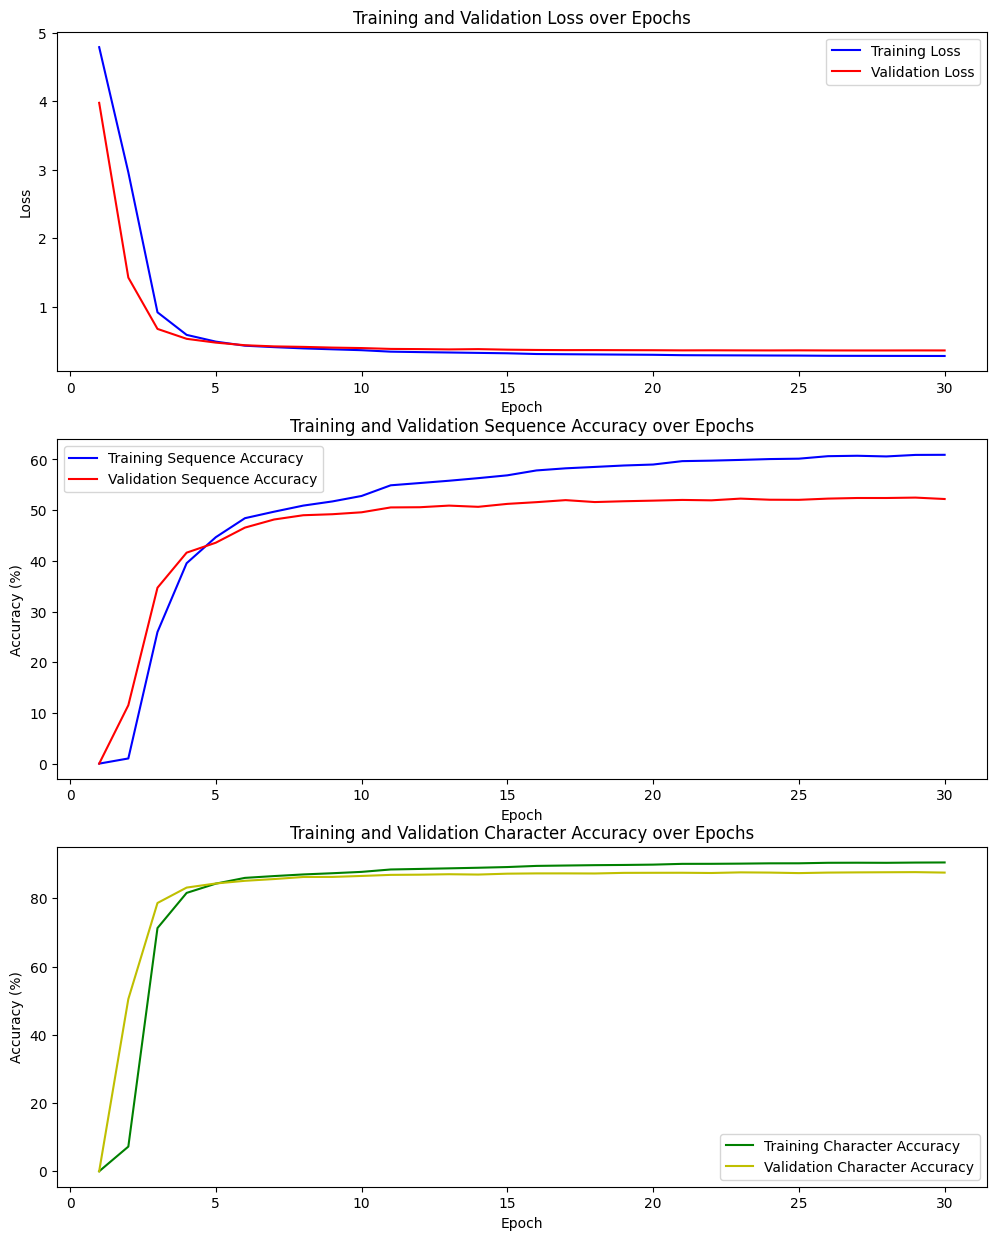

In [67]:
# Instantiate and Train the Model
model = OCRModel(num_classes=num_classes, hidden_size=256, num_layers=2)

# Start training with history and early stopping
train_model(model, train_loader, val_loader, num_epochs=30, device=device)

Initialize pre-trained model here

In [27]:
# Check for cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initalize model object
model = OCRModel(num_classes=num_classes, hidden_size=256, num_layers=2)
# Load in model from file
model.load_state_dict(torch.load("multi_ocr_model.pth", map_location=device))
model.eval()


<ipython-input-27-49d953e7472b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ocr_model.pth", map_location=device))


OCRModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(1024, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=63, bias=True)
)

Test model on test set

In [68]:
def test_model(model, test_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode
    criterion = nn.CTCLoss(blank=blank_idx, zero_infinity=True)  # Define CTC loss

    running_loss, correct_seqs, total_seqs, correct_chars, total_chars  = 0.0, 0, 0, 0, 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in tqdm(test_loader, desc="Testing"):
            # Move data to the specified device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(images)  # Output: [batch_size, seq_len, num_classes]
            outputs = outputs.permute(1, 0, 2)  # Transpose for CTC loss: [seq_len, batch_size, num_classes]
            outputs = F.log_softmax(outputs, dim=2)  # Apply log-softmax for CTC

            # Flatten targets for CTC loss
            targets = labels.contiguous().view(-1)  # Flatten: [batch_size * seq_len]

            # Define input_lengths and target_lengths for CTC
            batch_size = images.size(0)
            input_lengths = torch.full((batch_size,), outputs.size(0), dtype=torch.long, device=device)  # (batch_size)
            target_lengths = torch.tensor([len(t) for t in labels], dtype=torch.long, device=device)  # Ground-truth lengths


            # Compute the CTC loss
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            running_loss += loss.item()

            # Decode model predictions
            decoded_sequences = greedy_decode(outputs.detach().cpu(), blank=blank_idx)
            target_sequences = labels.detach().cpu().tolist()

            # Compute sequence and character-level accuracy
            for i in range(len(decoded_sequences)):
                pred = decoded_sequences[i]
                target = target_sequences[i]

                # Check sequence-level accuracy
                if pred == target:
                    correct_seqs += 1

                # Check character-level accuracy
                for j in range(len(target)):
                    if j < len(pred) and pred[j] == target[j]:
                        correct_chars += 1
                total_chars += len(target)

            total_seqs += len(decoded_sequences)

    # Compute metrics
    test_loss = running_loss / len(test_loader)
    sequence_accuracy = correct_seqs / total_seqs * 100
    character_accuracy = correct_chars / total_chars * 100

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Sequence Accuracy: {sequence_accuracy:.2f}%")
    print(f"Test Character Accuracy: {character_accuracy:.2f}%")

    # Return results as a dictionary
    return {
        'test_loss': test_loss,
        'test_seq_acc': sequence_accuracy,
        'test_char_acc': character_accuracy
    }


# Example usage:
test_results = test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Testing: 100%|██████████| 79/79 [00:01<00:00, 44.93it/s]

Test Loss: 0.3549
Test Sequence Accuracy: 52.58%
Test Character Accuracy: 87.76%
